In [2]:
import pandas as pd # for data manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for advanced data visualization

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler, LabelEncoder # for data preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve 

df = pd.read_csv('data.csv')


print(df.head())
print(df.info())
print(df.describe())
print(df['diagnosis'].value_counts())  

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [3]:
df = df.drop('id', axis=1)

In [4]:
if 'Unnamed: 32' in df.columns:
    df = df.drop(columns=['Unnamed: 32'])

In [5]:
print(df.shape)
print(df.isnull().sum())


(569, 31)
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [6]:
le = LabelEncoder() 
df['diagnosis'] = le.fit_transform(df['diagnosis']) # Encodes the diagnosis labels into numerical values

In [7]:
# Split features and target values
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, stratify=y_train_full, random_state=42) # test_size=0.1765 for making the validation set as the test set (15% of the total data)

In [9]:
# Normalizing the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_val_pred_rf = rf_model.predict(X_val)
y_val_prob_rf = rf_model.predict_proba(X_val)[:,1]

print("==== Random Forest Validation Metrics ====")
print(classification_report(y_val, y_val_pred_rf))

auc_rf = roc_auc_score(y_val, y_val_prob_rf)
print(f"AUC-ROC: {auc_rf:.3f}")

==== Random Forest Validation Metrics ====
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       0.97      0.94      0.95        32

    accuracy                           0.97        86
   macro avg       0.97      0.96      0.96        86
weighted avg       0.97      0.97      0.96        86

AUC-ROC: 0.995


In [11]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), # the GridSearchCV searches for the best hyperparameters
                           param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_) 

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [12]:
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)[:,1]

print("==== Random Forest Test Metrics ====")
print(classification_report(y_test, y_test_pred))
cm_test = confusion_matrix(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_prob)
print(f"AUC-ROC: {auc_test:.3f}")

==== Random Forest Test Metrics ====
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       1.00      0.91      0.95        32

    accuracy                           0.97        86
   macro avg       0.97      0.95      0.96        86
weighted avg       0.97      0.97      0.96        86

AUC-ROC: 0.999


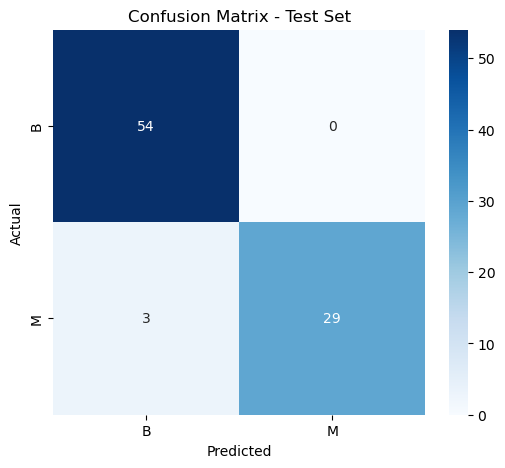

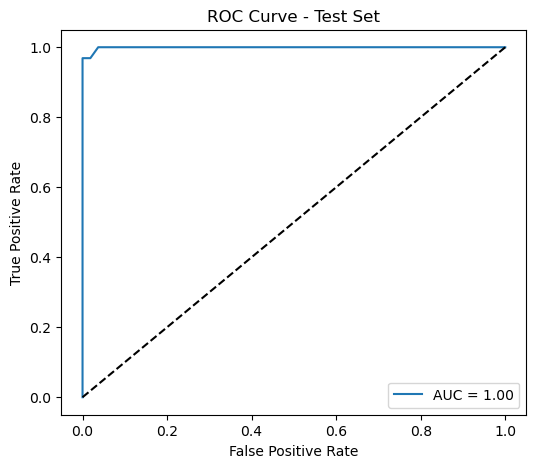

In [13]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['B','M'], yticklabels=['B','M'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_test:.2f}')
plt.plot([0,1],[0,1],'k--') # diagonal line means the model is random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.show()

In [14]:
# SVM Classification model

from sklearn.svm import SVC

In [15]:
X_train_svm , X_test_svm , y_train_svm , y_test_svm = train_test_split (X, y, test_size=0.3, random_state=42, stratify=y) # stratify to maintain the class distribution after split

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

In [17]:
print(X_test_svm)

[[ 0.11370189 -0.02275677  0.09606345 ... -0.28246087 -0.6867991
  -0.50694561]
 [-0.58232143 -0.12467915 -0.6243373  ... -0.96021507 -0.04883621
  -0.16645399]
 [-1.79402194  1.18178047 -1.80138774 ... -1.72711179 -0.06287451
  -0.73979795]
 ...
 [ 0.0827049   0.0768492   0.10548313 ...  0.62944303 -0.30152567
   0.53100466]
 [-0.61895423  0.48453872 -0.62966146 ... -0.6358688  -0.73827288
   0.08507047]
 [ 1.52265596  3.01869976  1.4782991  ...  0.71979018 -0.30932473
  -0.44928171]]


=== Kernel: linear ===
              precision    recall  f1-score   support

           B       0.95      1.00      0.97       107
           M       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



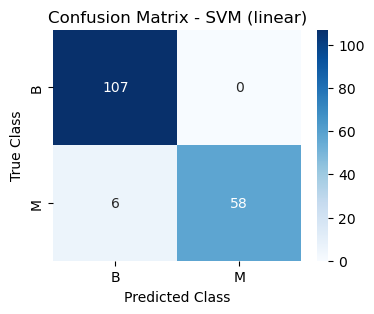

=== Kernel: poly ===
              precision    recall  f1-score   support

           B       0.84      1.00      0.91       107
           M       1.00      0.69      0.81        64

    accuracy                           0.88       171
   macro avg       0.92      0.84      0.86       171
weighted avg       0.90      0.88      0.88       171



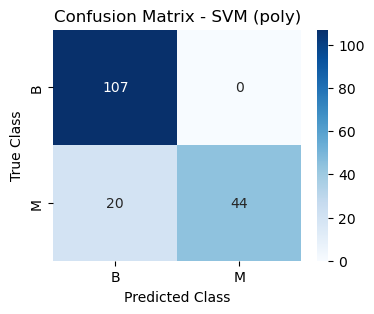

=== Kernel: rbf ===
              precision    recall  f1-score   support

           B       0.94      1.00      0.97       107
           M       1.00      0.89      0.94        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



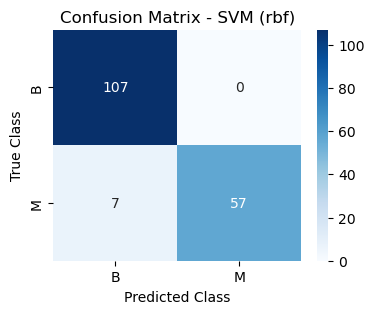

In [19]:
kernels = ['linear', 'poly', 'rbf']
target_names = ['B', 'M']  # Benign, Malignant

for kernel_type in kernels:
    svm_clf = SVC(kernel=kernel_type, random_state=42)
    svm_clf.fit(X_train_svm, y_train_svm)
    y_pred = svm_clf.predict(X_test_svm)
    
    print(f"=== Kernel: {kernel_type} ===")
    print(classification_report(y_test_svm, y_pred, target_names=target_names))
    
    cm = confusion_matrix(y_test_svm, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix - SVM ({kernel_type})")
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()